In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
raw_data = pd.read_csv('data/clean_data.csv')

In [3]:
raw_data.head()

,Yr,Reporting_Entity_RIC_Name,Partner_Entity_RIC_Name,Flow,Reporting_Entity_Continent,Reporting_Entity_Type,Partner_Entity_Continent,Partner_Entity_Type
0,1792,France,Austria,13541271.0,Europe,Country,Europe,Country
1,1792,France,Germany,12300406.0,Europe,Country,Europe,Country
2,1792,France,Netherlands,21864951.0,Europe,Country,Europe,Country
3,1792,France,Portugal,1334107.0,Europe,Country,Europe,Country
4,1792,France,Prussia,2294328.0,Europe,Country,Europe,Country


### GTC_Functions

In [4]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

# data importing
raw_data = pd.read_csv('data/clean_data.csv')

class Graph_GT:
    def __init__(self, year, raw_data = raw_data):
        """
        Initialization
        self.df is a pd.dataframe for the given year
        """

        self.year = year
        self.df = raw_data.loc[raw_data['Yr']==year]
 

    def country_list(self):
        """
        raw_date should be a pd.dataframe
        
        """
        country_list = set(list(self.df.Reporting_Entity_RIC_Name)\
                           +list(self.df.Partner_Entity_RIC_Name))
        country_list = sorted(list(country_list))
        return country_list
    
    
    def graph(self):
        """
        creat a nx.graph object(weighted & directed)
        of the trading data for the given year
        """
        
        list_trade = self.df.iloc[:,[1,2,3]].values
#         list_trade_nanremoved = []
#         for row in list_trade:
#             if np.isnan(row[2]) == False:
#                 list_trade_nanremoved +=  [row]
        list_trade = np.array(list_trade)

        #min_max_scaler = preprocessing.MinMaxScaler()
        #
        #list_trade[:,2] = min_max_scaler.fit_transform(list_trade[:,2])       
        #list_trade[:,2] = preprocessing.scale(list_trade[:,2])

        G = nx.Graph()
        nodes = []
        for row in list_trade:

            G.add_edge(row[0],row[1])
            nodes.append(row[0])
            nodes.append(row[1])
        nodes = set(nodes)
        G.add_nodes_from(nodes)
        return G
    


In [5]:
GT1920 = Graph_GT(year = 1920)

In [6]:
gra = GT1920.graph()

## Louvain Methode

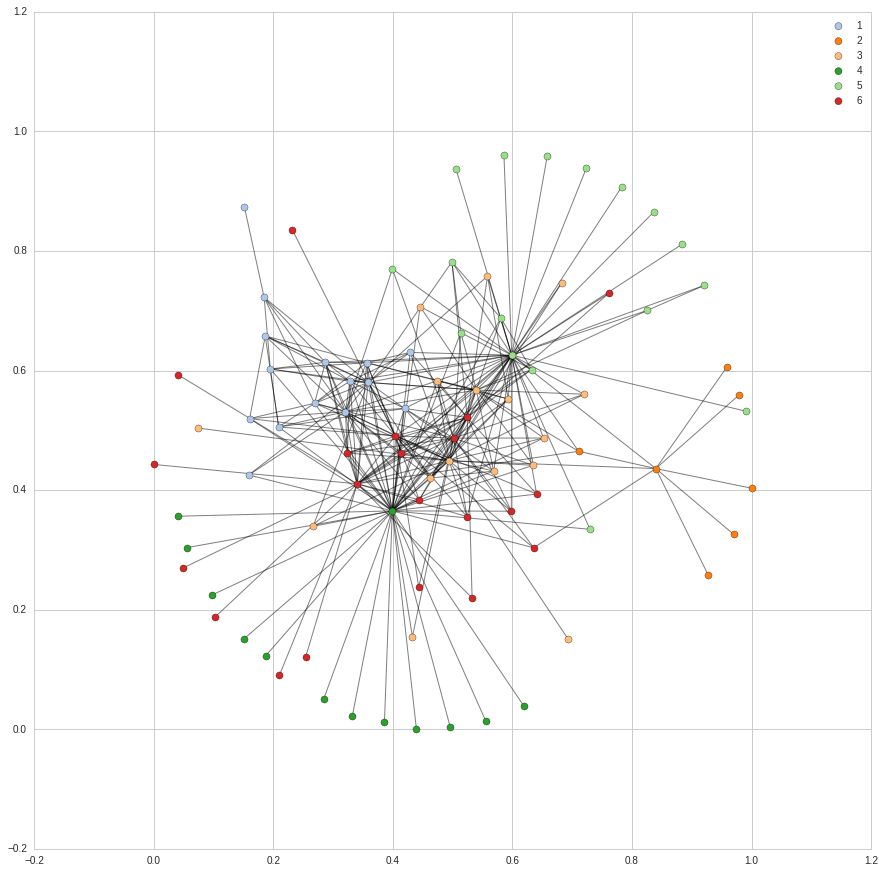

In [76]:
G = Graph_GT(year = 1840).graph()
import community_louvain

plt.figure(figsize = [15,15])
#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure

#first compute the best partition
partition = community_louvain.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.fruchterman_reingold_layout(G)
#pos = nx.spring_layout(G)
count = 0


colors = ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
          ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
          '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']

for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count],label = count)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.5)

plt.show()


## Spectral Clustering

In [15]:
Lap_nom = nx.normalized_laplacian_matrix(G).todense()

/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


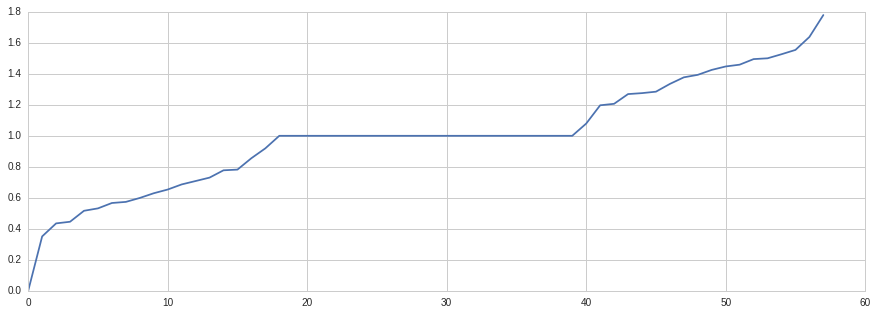

In [16]:
plt.figure(figsize = [15,5])
eig_val, eig_vec = np.linalg.eig(Lap_nom)
plt.plot(sorted(np.linalg.eig(Lap_nom)[0][0:58]))

In [17]:
k = 12
selected_vec = np.zeros([len(eig_val),k])
thr = sorted(eig_val)[k-1]
eig_val, eig_vec = np.linalg.eig(Lap_nom)
ind = 0
for i in range(len(eig_val)):
    if eig_val[i]<=thr:
        selected_vec[:,ind] = np.array(eig_vec)[:,i]
        ind += 1
        

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part


In [18]:
X = selected_vec

In [19]:
cluster_km = KMeans(n_clusters = 8,max_iter = 10000,tol = 0.00000001)
features_spectre = X
cluster_km.fit(features_spectre)
pred = cluster_km.predict(X)

dict_predict = {}
for i in range(len(G.nodes())):
    dict_predict.update(
    {
            G.nodes()[i] : int(pred[i])
        })

In [20]:
#dict_predict

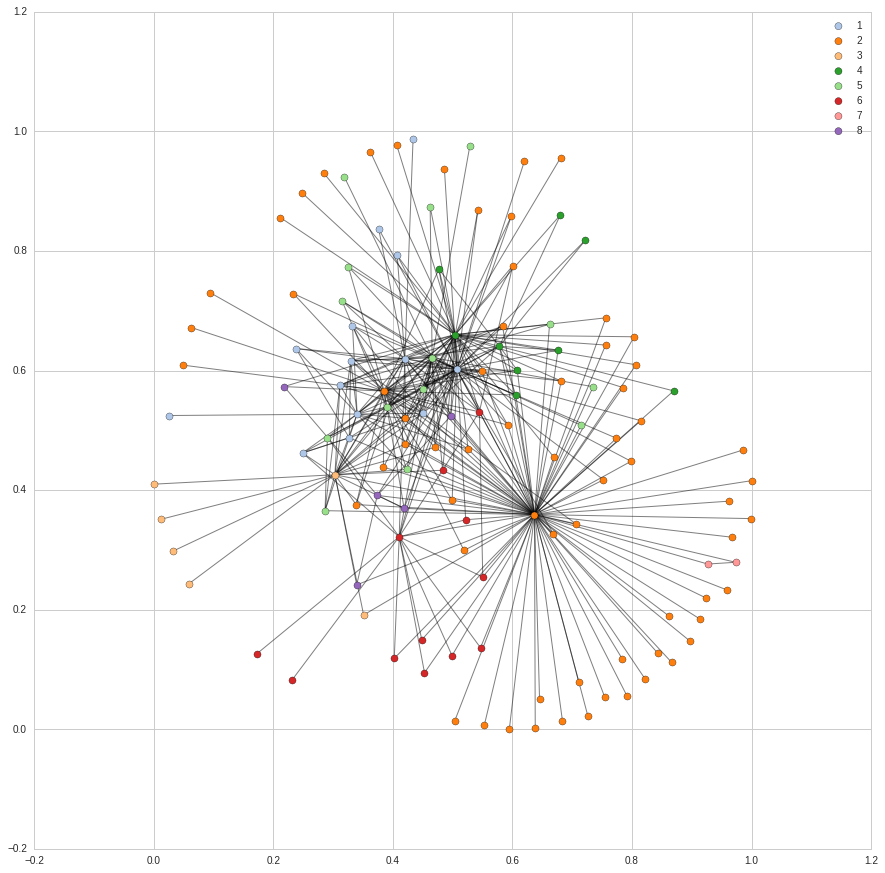

In [21]:
plt.figure(figsize = [15,15])
count = 0
for com in set(dict_predict.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in dict_predict.keys()
                                if dict_predict[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count],label = count)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.5)

plt.show()


## Calculation of Conductance 

In [22]:
from __future__ import division

from itertools import chain

import networkx as nx

__all__ = ['boundary_expansion', 'conductance', 'cut_size', 'edge_expansion',
           'mixing_expansion', 'node_expansion', 'normalized_cut_size',
           'volume']

def cut_size(G, S, T=None, weight=None):
    """Returns the size of the cut between two sets of nodes.

    A *cut* is a partition of the nodes of a graph into two sets. The
    *cut size* is the sum of the weights of the edges "between" the two
    sets of nodes.

    Parameters
    ----------
    G : NetworkX graph

    S : sequence
        A sequence of nodes in `G`.

    T : sequence
        A sequence of nodes in `G`. If not specified, this is taken to
        be the set complement of `S`.

    weight : object
        Edge attribute key to use as weight. If not specified, edges
        have weight one.

    Returns
    -------
    number
        Total weight of all edges from nodes in set `S` to nodes in
        set `T` (and, in the case of directed graphs, all edges from
        nodes in `T` to nodes in `S`).

    Examples
    --------
    In the graph with two cliques joined by a single edges, the natural
    bipartition of the graph into two blocks, one for each clique,
    yields a cut of weight one::

        >>> G = nx.barbell_graph(3, 0)
        >>> S = {0, 1, 2}
        >>> T = {3, 4, 5}
        >>> nx.cut_size(G, S, T)
        1

    Each parallel edge in a multigraph is counted when determining the
    cut size::

        >>> G = nx.MultiGraph(['ab', 'ab'])
        >>> S = {'a'}
        >>> T = {'b'}
        >>> nx.cut_size(G, S, T)
        2

    Notes
    -----
    In a multigraph, the cut size is the total weight of edges including
    multiplicity.

    """
    edges = nx.edge_boundary(G, S, T)
    if G.is_directed():
        edges = chain(edges, nx.edge_boundary(G, T, S))
    return sum(1 for u, v in edges)




def volume(G, S):
    """Returns the volume of a set of nodes.

    """
    degree = G.degree
    #return sum(d for v, d in degree(S))
    return len(S)





def conductance(G, S, T=None, weight=None):
    """Returns the conductance of two sets of nodes.

    The *conductance* is the quotient of the cut size and the smaller of
    the volumes of the two sets. [1]

    Parameters
    ----------
    G : NetworkX graph

    S : sequence
        A sequence of nodes in `G`.

    T : sequence
        A sequence of nodes in `G`.

    weight : object
        Edge attribute key to use as weight. If not specified, edges
        have weight one.

    Returns
    -------
    number
        The conductance between the two sets `S` and `T`.

    See also
    --------
    cut_size
    edge_expansion
    normalized_cut_size
    volume

    References
    ----------
    .. [1] David Gleich.
           *Hierarchical Directed Spectral Graph Partitioning*.
           <https://www.cs.purdue.edu/homes/dgleich/publications/Gleich%202005%20-%20hierarchical%20directed%20spectral.pdf>

    """
    if T is None:
        T = set(G) - set(S)
    num_cut_edges = cut_size(G, S, T)
    volume_S = volume(G, S)
    volume_T = volume(G, T)
    return num_cut_edges / min(volume_S, volume_T)






In [23]:
def get_cluster_nodes_from_dict(cluster_index,dict_predict):
    """
    return the nodes of a certain cluster
    """
    return {k:v for (k,v) in dict_predict.items() if v==cluster_index}.keys()

In [24]:
#test
conductance(G,get_cluster_nodes_from_dict(4,dict_predict),get_cluster_nodes_from_dict(2,dict_predict))
nx.edge_boundary(G,get_cluster_nodes_from_dict(4,dict_predict),get_cluster_nodes_from_dict(2,dict_predict))

[('Netherlands', 'Russia/USSR'),
 ('Finland', 'Russia/USSR'),
 ('Bremen', 'Russia/USSR'),
 ('Norway', 'Russia/USSR')]

In [25]:
def conductance_by_index(index_1, index_2,dict_predict = dict_predict, G = G):
    return conductance(G,get_cluster_nodes_from_dict(index_1,dict_predict),get_cluster_nodes_from_dict(index_2,dict_predict))

In [26]:


##function to 

## Overlapping clustering

In [13]:
from collections import defaultdict
import networkx as nx

__all__ = ['k_clique_communities']


def k_clique_communities(G, k, cliques=None):
    """Find k-clique communities in graph using the percolation method.

    A k-clique community is the union of all cliques of size k that
    can be reached through adjacent (sharing k-1 nodes) k-cliques.

    Parameters
    ----------
    G : NetworkX graph

    k : int
       Size of smallest clique

    cliques: list or generator       
       Precomputed cliques (use networkx.find_cliques(G))

    Returns
    -------
    Yields sets of nodes, one for each k-clique community.

    Examples
    --------
    >>> G = nx.complete_graph(5)
    >>> K5 = nx.convert_node_labels_to_integers(G,first_label=2)
    >>> G.add_edges_from(K5.edges())
    >>> c = list(nx.k_clique_communities(G, 4))
    >>> list(c[0])
    [0, 1, 2, 3, 4, 5, 6]
    >>> list(nx.k_clique_communities(G, 6))
    []

    References
    ----------
    .. [1] Gergely Palla, Imre Derényi, Illés Farkas1, and Tamás Vicsek,
       Uncovering the overlapping community structure of complex networks 
       in nature and society Nature 435, 814-818, 2005,
       doi:10.1038/nature03607
    """
    if k < 2:
        raise nx.NetworkXError("k=%d, k must be greater than 1."%k)
    if cliques is None:
        cliques = nx.find_cliques(G)
    cliques = [frozenset(c) for c in cliques if len(c) >= k]

    # First index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    # For each clique, see which adjacent cliques percolate
    perc_graph = nx.Graph()
    perc_graph.add_nodes_from(cliques)
    for clique in cliques:
        for adj_clique in _get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    # Connected components of clique graph with perc edges
    # are the percolated cliques
    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

def _get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    for n in clique:
        for adj_clique in membership_dict[n]:
            if clique != adj_clique:
                adjacent_cliques.add(adj_clique)
    return adjacent_cliques

In [11]:
k_clique_coef = 6
G = Graph_GT(year = 1860).graph()

overlap_list = []

for i in range(len(list(nx.k_clique_communities(G,k_clique_coef)))):
    
    overlap_list += [list(list(nx.k_clique_communities(G,k_clique_coef))[i])]

In [23]:
pred = []
for j in range(len(list(nx.k_clique_communities(G,k_clique_coef)))):
    for i in range(len(G.nodes())):
    
        if G.nodes()[i] in overlap_list[j]:
            pred += [j+1]
        else:
            pred +=[0]
    

In [25]:
dict_predict = {}
for i in range(len(G.nodes())):
    dict_predict.update(
    {
            G.nodes()[i] : int(pred[i])
        })

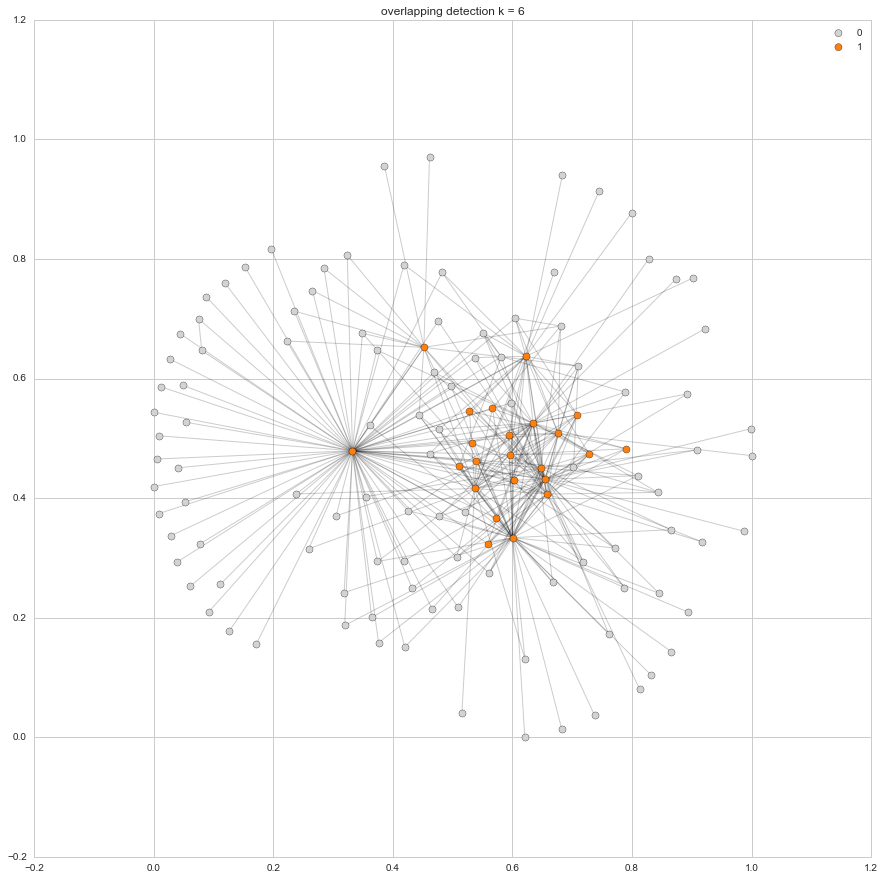

In [29]:
plt.figure(figsize = [15,15])

pos = nx.fruchterman_reingold_layout(G)
#pos = nx.spring_layout(G)
count = 0


# colors = ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
#           ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
#           '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']
colors = ['lightgrey', '#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
           ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
           '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']
for com in set(dict_predict.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in dict_predict.keys()
                                if dict_predict[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count-1],label = count-1)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.2)
plt.title('overlapping detection k = '+ str(k_clique_coef))
plt.show()